# Extracting CMA (Census Metropolitan Area) Boundaries


#### Process

- Load Canadian Census Geometries
- Extract boundaries for each city
- Extract DAs for each CMA
- Save Data

- Canada: https://www.statcan.gc.ca/eng/subjects/standard/daily/5000076
- US blocks: https://www.census.gov/cgi-bin/geo/shapefiles/index.php
- NYC: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
- Chicago: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk
- Seattle: http://data-seattlecitygis.opendata.arcgis.com/datasets/seattle-city-limits
- San Francisco: 
    - https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h
    - https://geodata.lib.berkeley.edu/catalog/stanford-vj593xs7263

In [20]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from src.data.census.canada.prepare_ca_data import get_citybounds
import os

### US Cities

In [17]:
city = "miami"
country = "united_states"
country_initials = "US"
geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.geojson')

In [2]:
# load city boundaries
NYC = gpd.read_file('data/raw/US_geographies/newYork/geo_export_924ea892-90ca-4cd0-9df7-afa8ecdf8fe6.shp')
CHI = gpd.read_file('data/raw/US_geographies/illinois/geo_export_6635c3da-0e6d-4cf4-975c-70f8b54e4aa9.shp')
SE = gpd.read_file('data/raw/US_geographies/washington/City_Clerk_Neighborhoods.shp')
SF = gpd.read_file('data/raw/US_geographies/california/ba_cities.shp')

# # load city blocks
# NYC_B = gpd.read_file('data/raw/US_geographies/newYork/tl_2019_36_tabblock10.shp')
# CHI_B = gpd.read_file('data/raw/US_geographies/illinois/tl_2019_17_tabblock10.shp')
# SE_B = gpd.read_file('data/raw/US_geographies/washington/tl_2019_53_tabblock10.shp')
# SF_B = gpd.read_file('data/raw/US_geographies/california/tl_2019_06_tabblock10.shp')

# load city block groups
# NYC_BG = gpd.read_file('data/raw/US_geographies/newYork/cb_2018_36_bg_500k.shp')
# CHI_BG = gpd.read_file('data/raw/US_geographies/illinois/cb_2018_17_bg_500k.shp')
# SE_BG = gpd.read_file('data/raw/US_geographies/washington/cb_2018_53_bg_500k.shp')
# SF_BG = gpd.read_file('data/raw/US_geographies/california/cb_2018_06_bg_500k.shp')

In [18]:
city_area = get_citybounds(geometry)
city_area = city_area.to_crs({'init' :'epsg:4326'})
city_area.to_file(f'../../data/interim/census/CensusBoundaries_{country_initials}/{city}_AREA.geojson', driver = 'GeoJSON')

C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


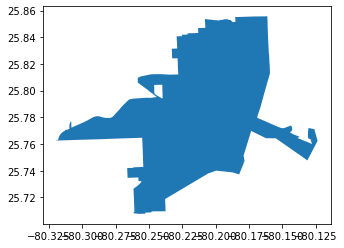

In [19]:
city_area.plot()

### Canadian cities
All canadian metropolitan areas greater than 1 million people
https://en.wikipedia.org/wiki/Template:Largest_metropolitan_areas_of_Canada

In [2]:
canada = gpd.read_file(r"data\raw\geographies\lda_000b16a_e.shp")

In [3]:
#function for extracting metropolitan census blocks
def get_metrocensus(canada=canada, MAID=[], MANAMES=[], PROVFILTER=[]): 
    '''filters canadian census layer by metropolitan area, The result is census blocks for a given metropolitan area'''
    #filter by metropolitan area
    if MAID != []:
        MAREA = canada[canada.CMAPUID.isin(MAID)]
        return MAREA
    elif MAID == []:
        MAREA = canada[canada.CDNAME.isin(MANAMES) & ~canada.PRUID.isin(PROVFILTER)]
        return MAREA

In [3]:
#function for extracting metropolitan boundaries
def get_metrobounds(canada=canada, MAID=[], MANAMES=[], PROVFILTER=[]): 
    '''filters canadian census layer by metropolitan area, and dissolves all polygons. The result is metropolitan boundaries'''
    #create new col to be used with dissolve
    canada['COUNTRY'] = 1
    if MAID != []:
        MAREA = canada[canada.CMAPUID.isin(MAID)]
        MAREA = MAREA.dissolve(by='COUNTRY')
        MAREA = MAREA[['CMANAME', 'geometry']]
        return MAREA
    elif MAID == []:
        MAREA = canada[canada.CDNAME.isin(MANAMES) & ~canada.PRUID.isin(PROVFILTER)]
        MAREA = MAREA.dissolve(by='COUNTRY')
        MAREA = MAREA[['CMANAME', 'geometry']]
        return MAREA   

In [6]:
#function for extracting city boundaries blocks
def get_citybounds(canada=None, NAMES=[]): 
    '''filters canadian census layer by metropolitan area, and dissolves all polygons. The result is metropolitan boundaries'''
    #create new col to be used with dissolve
    canada['COUNTRY'] = 1
    MAREA = canada[canada.CCSNAME.isin(NAMES)]
    MAREA = MAREA.dissolve(by='COUNTRY')
    MAREA = MAREA[['CMANAME', 'geometry']]
    
    return MAREA

In [ ]:
## BLOCKS
#get metro toronto
MTBLOCKS = get_metrocensus(canada=canada, MANAMES=['Toronto', 'Hamilton', 'Durham', 'Halton', 'Peel', 'York'], PROVFILTER=['13'])
MTBLOCKS = MTBLOCKS.to_crs({'init' :'epsg:4326'})
MTBLOCKS.to_file(r'data\interim\census\CensusBlocks\MTBLOCKS.shp')
#get metro vancouver
MVBLOCKS = get_metrocensus(canada=canada, MAID=['59933'])
MVBLOCKS = MVBLOCKS.to_crs({'init' :'epsg:4326'})
MVBLOCKS.to_file(r'data\interim\census\CensusBlocks\MVBLOCKS.shp')
##statscan says that metro toronto is this: "CMAPUID" IN ('35535') but it doesnt make sense.. investigate!
#get metro montreal
MMBLOCKS = get_metrocensus(canada=canada, MAID=['24462'])
MMBLOCKS = MMBLOCKS.to_crs({'init' :'epsg:4326'})
MMBLOCKS.to_file(r'data\interim\census\CensusBlocks\MMBLOCKS.shp')
#get Ottawa-Gattineau
MOBLOCKS = get_metrocensus(canada=canada, MAID=['35505', '24505'])
MOBLOCKS = MOBLOCKS.to_crs({'init' :'epsg:4326'})
MOBLOCKS.to_file(r'data\interim\census\CensusBlocks\MOBLOCKS.shp')
#get metro calgary
MCBLOCKS = get_metrocensus(canada=canada, MAID=['48825'])
MCBLOCKS = MCBLOCKS.to_crs({'init' :'epsg:4326'})
MCBLOCKS.to_file(r'data\interim\census\CensusBlocks\MCBLOCKS.shp')
#get metro edmonton
MEBLOCKS = get_metrocensus(canada=canada, MAID=['48835'])
MEBLOCKS = MEBLOCKS.to_crs({'init' :'epsg:4326'})
MEBLOCKS.to_file(r'data\interim\census\CensusBlocks\MEBLOCKS.shp')

In [10]:
# BOUNDARIES: Cities
CTAREA = get_citybounds(canada=canada, NAMES=['Toronto'])
CTAREA = CTAREA.to_crs({'init' :'epsg:4326'})
CTAREA.to_file(r'data\interim\census\CensusBoundaries_CA\CTAREA.shp')
#get metro vancouver
CVAREA = get_citybounds(canada=canada, NAMES=['Vancouver'])
CVAREA = CVAREA.to_crs({'init' :'epsg:4326'})
CVAREA.to_file(r'data\interim\census\CensusBoundaries_CA\CVAREA.shp')
#get metro montreal
CMAREA = get_citybounds(canada=canada, NAMES=['Montréal'])
CMAREA = CMAREA.to_crs({'init' :'epsg:4326'})
CMAREA.to_file(r'data\interim\census\CensusBoundaries_CA\CMAREA.shp')
#get Ottawa-Gattineau
COAREA = get_citybounds(canada=canada, NAMES=['Ottawa'])
COAREA = COAREA.to_crs({'init' :'epsg:4326'})
COAREA.to_file(r'data\interim\census\CensusBoundaries_CA\COAREA.shp')
#get metro calgary
CCAREA = get_citybounds(canada=canada, NAMES=['Calgary'])
CCAREA = CCAREA.to_crs({'init' :'epsg:4326'})
CCAREA.to_file(r'data\interim\census\CensusBoundaries_CA\CCAREA.shp')
#get metro edmonton
CEAREA = get_citybounds(canada=canada, NAMES=['Edmonton'])
CEAREA = CEAREA.to_crs({'init' :'epsg:4326'})
CEAREA.to_file(r'data\interim\census\CensusBoundaries_CA\CEAREA.shp')

C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Leonardo\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis or

In [ ]:
# BOUNDARIES: Metro Areas
#get metro toronto
MTAREA = get_metrobounds(canada=canada, MANAMES=['Toronto', 'Hamilton', 'Durham', 'Halton', 'Peel', 'York'], PROVFILTER=['13'])
MTAREA = MTAREA.to_crs({'init' :'epsg:4326'})
MTAREA.to_file(r'data\interim\census\CensusBoundaries\MTAREA.shp')
#get metro vancouver
MVAREA = get_metrobounds(canada=canada, MAID=['59933'])
MVAREA = MVAREA.to_crs({'init' :'epsg:4326'})
MVAREA.to_file(r'data\interim\census\CensusBoundaries\MVAREA.shp')
#get metro montreal
MMAREA = get_metrobounds(canada=canada, MAID=['24462'])
MMAREA = MMAREA.to_crs({'init' :'epsg:4326'})
MMAREA.to_file(r'data\interim\census\CensusBoundaries\MMAREA.shp')
#get Ottawa-Gattineau
MOAREA = get_metrobounds(canada=canada, MAID=['35505', '24505'])
MOAREA = MOAREA.to_crs({'init' :'epsg:4326'})
MOAREA.to_file(r'data\interim\census\CensusBoundaries\MOAREA.shp')
#get metro calgary
MCAREA = get_metrobounds(canada=canada, MAID=['48825'])
MCAREA = MCAREA.to_crs({'init' :'epsg:4326'})
MCAREA.to_file(r'data\interim\census\CensusBoundaries\MCAREA.shp')
#get metro edmonton
MEAREA = get_metrobounds(canada=canada, MAID=['48835'])
MEAREA = MEAREA.to_crs({'init' :'epsg:4326'})
MEAREA.to_file(r'data\interim\census\CensusBoundaries\MEAREA.shp')

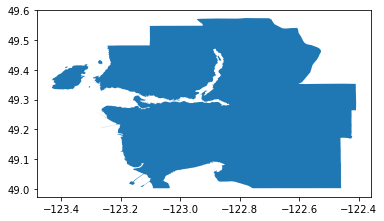

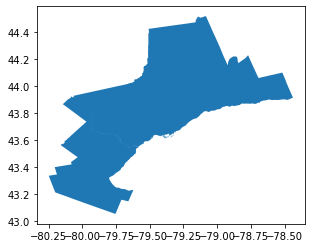

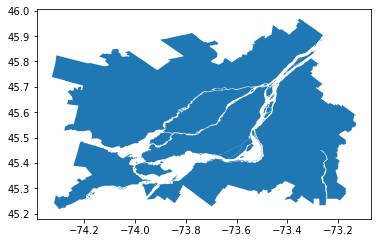

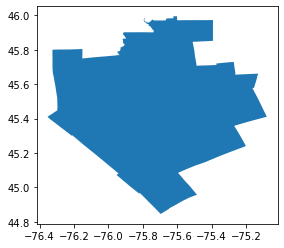

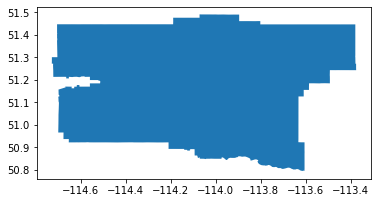

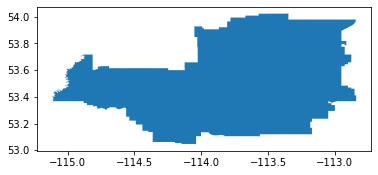

In [7]:
MVAREA.plot()
MTAREA.plot()
MMAREA.plot()
MOAREA.plot()
MCAREA.plot()
MEAREA.plot()
plt.show()